## Data Preparation and Pre-Processing:

Total patients: 43399
Patients who received CT: 15899
Patients with positive CT: 1156

CT scan rate by PECARN risk category:


Received_CT,False,True
PECARN_Risk,,
High risk,12.878788,87.121212
Intermediate risk,70.207400,29.792600
Low risk,86.115007,13.884993


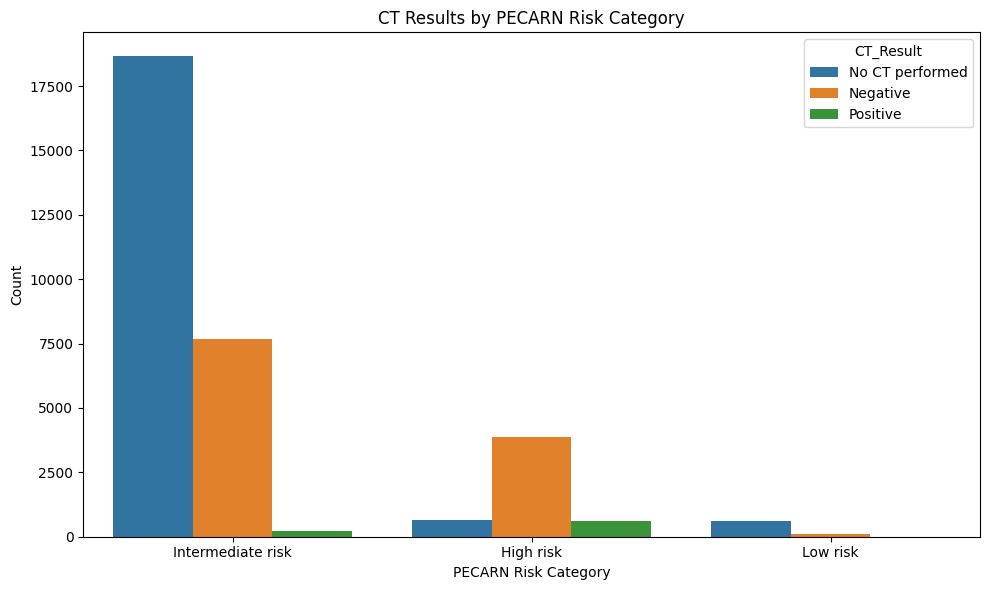

Dataset saved to ./data
CT Decision dataset shape: (43399, 11)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#load peacarn dataset
data_path = '/Users/andrechu/Desktop/UnivUtah/BMI6016/PEACARN/Data/TBI PUD 10-08-2013.csv'
tbi_data = pd.read_csv(data_path)

#cleaned version that will have proper handling of special codes
tbi_clean = tbi_data.copy()

#handle special codes for key clinical variables
def recode_special_values(df, var_name, special_codes_map, default_na_value=np.nan):
    """
    Recodes special values in variables based on provided mapping
    
    Parameters:
    - df: DataFrame containing the data
    - var_name: Name of the variable to recode
    - special_codes_map: Dictionary mapping special codes to their meaning
    - default_na_value: Value to use for NaN values if not in mapping
    
    Returns:
    - Series with recoded values
    """
    #base case
    if var_name not in df.columns:
        return None
        
    recoded = df[var_name].copy()
    
    #recode special values
    for code, meaning in special_codes_map.items():
        recoded = recoded.replace(code, meaning)
    
    #handle NaN values if not in mapping
    if np.nan not in special_codes_map and default_na_value is not None:
        recoded = recoded.fillna(default_na_value)
        
    return recoded

#special code mappings for key variables
symptom_map = {
    0.0: 'Absent',
    1.0: 'Present',
    91.0: 'Unable to assess',
    np.nan: 'Not documented'
}

ct_result_map = {
    0.0: 'Negative',
    1.0: 'Positive',
    92.0: 'No CT performed',
    np.nan: 'Unknown'
}

loc_map = {
    0.0: 'No LOC',
    1.0: 'Brief LOC (<5 min)',
    2.0: 'Prolonged LOC (≥5 min)',
    np.nan: 'Not documented'
}

#apply recoding to key variables
tbi_clean['Amnesia_cat'] = recode_special_values(tbi_data, 'Amnesia_verb', symptom_map)
tbi_clean['Headache_cat'] = recode_special_values(tbi_data, 'HA_verb', symptom_map)
tbi_clean['LOC_cat'] = recode_special_values(tbi_data, 'LOCSeparate', loc_map)
tbi_clean['Vomit_cat'] = recode_special_values(tbi_data, 'Vomit', symptom_map)
tbi_clean['CT_Result'] = recode_special_values(tbi_data, 'PosCT', ct_result_map)

#create proper CT scan indicator 
tbi_clean['Received_CT'] = tbi_data['CTDone'] == 1

#create age groups
tbi_clean['Age_Group'] = pd.cut(
    tbi_data['AgeInMonth'],
    bins=[0, 24, 60, 120, 240],
    labels=['<2 years', '2-5 years', '5-10 years', '>10 years']
)

#create PECARN risk groups based on clinical criteria
# For children ≥2 years
mask_older = tbi_clean['Age_Group'] != '<2 years'
tbi_clean.loc[mask_older, 'PECARN_Risk'] = 'Low risk'

#altered mental status or signs of skull fracture would make it not low risk
mask_ams = (tbi_data['AMS'] == 1)
mask_skull_fx = (tbi_data['SFxPalp'] == 1)
mask_severe_mechanism = (tbi_data['High_impact_InjSev'] >= 2)
mask_loc = (tbi_data['LOCSeparate'] > 0)
mask_vomit = (tbi_data['Vomit'] == 1)
mask_severe_headache = (tbi_data['HASeverity'] >= 2)

#assign risk categories based on PECARN rule for ≥2 years
tbi_clean.loc[mask_older & (mask_ams | mask_skull_fx), 'PECARN_Risk'] = 'High risk'
tbi_clean.loc[mask_older & ~(mask_ams | mask_skull_fx) & 
              (mask_loc | mask_severe_headache | mask_vomit | mask_severe_mechanism), 
              'PECARN_Risk'] = 'Intermediate risk'

#prepare datasets for two-stage modeling
#dataset of all patientsfor CT decision model 
ct_decision_vars = [
    'Age_Group', 'GCSTotal', 'LOC_cat', 'Vomit_cat', 'Amnesia_cat', 
    'Headache_cat', 'High_impact_InjSev', 'SFxPalp', 'AMS', 'PECARN_Risk',
    'Received_CT'
]
ct_decision_data = tbi_clean[ct_decision_vars].copy()

#summary stats
print(f"Total patients: {len(tbi_clean)}")
print(f"Patients who received CT: {len(tbi_clean[tbi_clean['Received_CT']])}")
print(f"Patients with positive CT: {len(tbi_clean[tbi_clean['CT_Result'] == 'Positive'])}")

#relationship between PECARN risk and CT scan decision
risk_ct_table = pd.crosstab(
    tbi_clean['PECARN_Risk'], 
    tbi_clean['Received_CT'], 
    normalize='index'
) * 100

print("\nCT scan rate by PECARN risk category:")
display(risk_ct_table)

# Visualize relationship
plt.figure(figsize=(10, 6))
sns.countplot(x='PECARN_Risk', hue='CT_Result', data=tbi_clean)
plt.title('CT Results by PECARN Risk Category')
plt.xlabel('PECARN Risk Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Save the prepared datasets for modeling
output_dir = './data'
os.makedirs(output_dir, exist_ok=True)

# Save datasets
ct_decision_data.to_csv(os.path.join(output_dir, 'ct_decision_data.csv'), index=False)

print(f"Dataset saved to {output_dir}")
print(f"CT Decision dataset shape: {ct_decision_data.shape}")

## CT Decision Model 

Loaded CT Decision dataset with shape (43399, 11)
Numeric features: ['GCSTotal', 'High_impact_InjSev', 'SFxPalp', 'AMS']
Categorical features: ['Age_Group', 'LOC_cat', 'Vomit_cat', 'Amnesia_cat', 'Headache_cat', 'PECARN_Risk']

Training ensemble model for CT decision prediction...

Classification Report - Ensemble CT Decision Model:
              precision    recall  f1-score   support

       False       0.83      0.90      0.86      8250
        True       0.79      0.68      0.73      4770

    accuracy                           0.82     13020
   macro avg       0.81      0.79      0.80     13020
weighted avg       0.81      0.82      0.81     13020



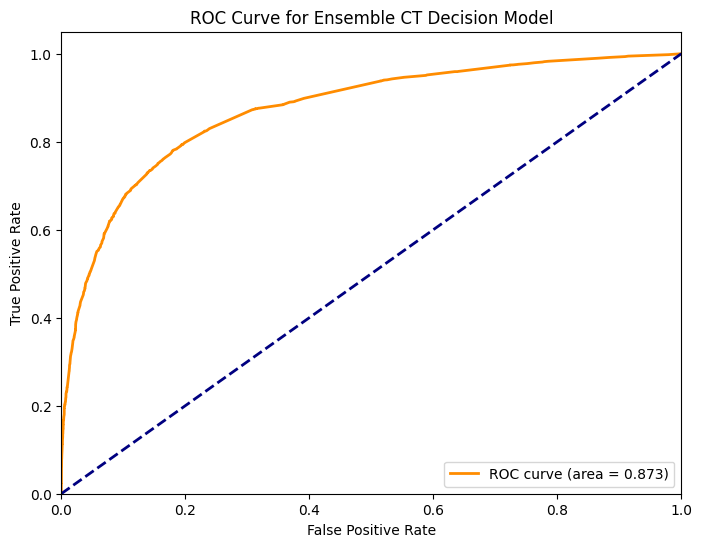


Optimized threshold (F2 score): 0.2077
At optimal threshold - Precision: 0.6179, Recall/Sensitivity: 0.8748
Sensitivity: 0.8748
Specificity: 0.6873
CT scans that would be ordered: 6753 (51.9%)

At standard threshold 0.3:
Sensitivity: 0.7977
Specificity: 0.8008
CT scans that would be ordered: 5448 (41.8%)

Random Forest Model Results:
              precision    recall  f1-score   support

       False       0.83      0.90      0.86      8250
        True       0.79      0.67      0.73      4770

    accuracy                           0.82     13020
   macro avg       0.81      0.79      0.80     13020
weighted avg       0.81      0.82      0.81     13020



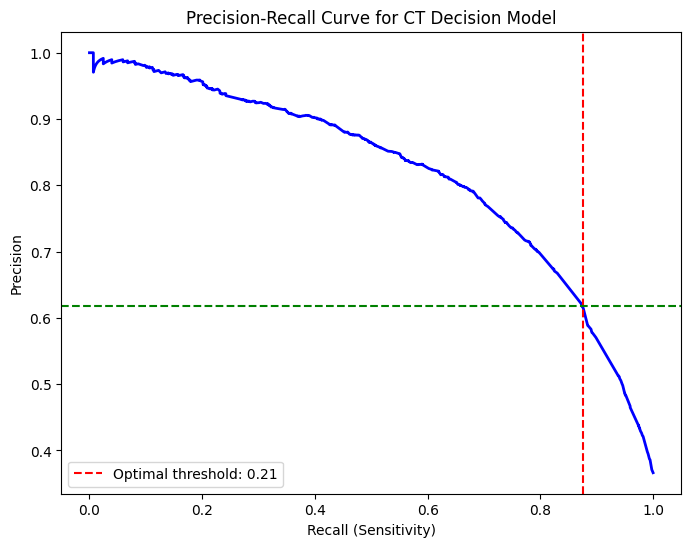


Top 10 Features for CT Decision (Random Forest):
                          Feature  Importance
9                  LOC_cat_No LOC    0.203434
3                             AMS    0.160781
23          PECARN_Risk_High risk    0.093263
8      LOC_cat_Brief LOC (<5 min)    0.082101
17            Amnesia_cat_Present    0.064771
12               Vomit_cat_Absent    0.061889
24  PECARN_Risk_Intermediate risk    0.054906
14              Vomit_cat_Present    0.054606
1              High_impact_InjSev    0.036549
0                        GCSTotal    0.030548

Improved CT Decision Model saved with optimal threshold.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle
import os

# Load prepared data
data_dir = './data'
ct_decision_data = pd.read_csv(os.path.join(data_dir, 'ct_decision_data.csv'))

# Convert categorical columns back to category type
categorical_columns = ['Age_Group', 'LOC_cat', 'Vomit_cat', 'Amnesia_cat', 'Headache_cat', 'PECARN_Risk']
for col in categorical_columns:
    if col in ct_decision_data.columns:
        ct_decision_data[col] = ct_decision_data[col].astype('category')

print(f"Loaded CT Decision dataset with shape {ct_decision_data.shape}")

#identify numeric and categorical columns
numeric_features = ct_decision_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_features if col != 'Received_CT']  # Remove target

categorical_features = ct_decision_data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = [col for col in categorical_features if col != 'Received_CT']  # Remove target if categorical

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

#create preprocessors for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

#split into features and target
X = ct_decision_data.drop('Received_CT', axis=1)
y = ct_decision_data['Received_CT']

#split test and training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#function to find optimal threshold based on F-beta score
def find_optimal_threshold(y_true, y_pred_proba, beta=2.0):
    """
    Find optimal threshold based on F-beta score
    beta > 1 gives more weight to recall (sensitivity)
    beta < 1 gives more weight to precision
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Add a small epsilon to avoid division by zero
    f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-10)
    # Exclude the last index because it has no corresponding threshold
    optimal_idx = np.argmax(f_beta_scores[:-1])
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, precision[optimal_idx], recall[optimal_idx], f_beta_scores[optimal_idx]

#create a voting ensemble model
ensemble_classifier = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42))
    ],
    voting='soft'
)

#full pipeline with the ensemble classifier
ct_decision_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ensemble_classifier)
])

#train the created pipeline
print("\nTraining ensemble model for CT decision prediction...")
ct_decision_pipeline.fit(X_train, y_train)

#model eval
y_pred = ct_decision_pipeline.predict(X_test)
y_pred_proba = ct_decision_pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report - Ensemble CT Decision Model:")
print(classification_report(y_test, y_pred))

#ROC curve plot
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ensemble CT Decision Model')
plt.legend(loc="lower right")
plt.show()

#calculate optimal threshold (optimized for recall with beta=2)
optimal_threshold, opt_precision, opt_recall, f_beta = find_optimal_threshold(
    y_test, y_pred_proba, beta=2.0
)

#calculate performance at optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
sensitivity_optimal = np.sum((y_pred_optimal == 1) & (y_test == 1)) / np.sum(y_test == 1)
specificity_optimal = np.sum((y_pred_optimal == 0) & (y_test == 0)) / np.sum(y_test == 0)

print(f"\nOptimized threshold (F2 score): {optimal_threshold:.4f}")
print(f"At optimal threshold - Precision: {opt_precision:.4f}, Recall/Sensitivity: {opt_recall:.4f}")
print(f"Sensitivity: {sensitivity_optimal:.4f}")
print(f"Specificity: {specificity_optimal:.4f}")
print(f"CT scans that would be ordered: {y_pred_optimal.sum()} ({y_pred_optimal.sum()/len(y_test)*100:.1f}%)")

#performance at standard threshold of 0.3 for comparison
threshold = 0.3
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
sensitivity = (y_pred_adjusted & y_test.values).sum() / y_test.sum()
specificity = (~y_pred_adjusted & ~y_test.values).sum() / (~y_test).sum()

print(f"\nAt standard threshold {threshold}:")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"CT scans that would be ordered: {y_pred_adjusted.sum()} ({y_pred_adjusted.sum()/len(y_test)*100:.1f}%)")

#train a Random Forest model 
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)
rf_pred_proba = rf_pipeline.predict_proba(X_test)[:, 1]

print("\nRandom Forest Model Results:")
print(classification_report(y_test, rf_pred))

#plot precision-recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, color='blue', lw=2)
plt.axvline(x=opt_recall, color='r', linestyle='--', 
            label=f'Optimal threshold: {optimal_threshold:.2f}')
plt.axhline(y=opt_precision, color='green', linestyle='--')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for CT Decision Model')
plt.legend(loc="lower left")
plt.show()

#feature importance extraction function
def get_feature_importance_from_pipeline(pipeline, categorical_features, numeric_features):
    """
    Extract feature importance from a sklearn pipeline with categorical features
    
    Parameters:
    - pipeline: Trained pipeline with preprocessor and classifier
    - categorical_features: List of categorical feature names
    - numeric_features: List of numeric feature names
    
    Returns:
    - DataFrame with feature names and importance values
    """
    #get classifier
    classifier = pipeline.named_steps['classifier']
    
    #for ensemble, use one of the underlying models
    if isinstance(classifier, VotingClassifier):
        classifier = classifier.estimators_[0][1]  # Use the first estimator (RF)
    
    #get the preprocessor
    preprocessor = pipeline.named_steps['preprocessor']
    
    #get the one-hot encoder
    ohe = preprocessor.transformers_[1][1].named_steps['onehot']
    
    #get transformed feature names for categorical variables
    cat_feature_names = ohe.get_feature_names_out(input_features=categorical_features)
    
    #combine using numeric features
    feature_names = np.array(numeric_features + list(cat_feature_names))
    
    #feature importances
    importances = classifier.feature_importances_
    
    #DataFrame used visualization
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    return feature_importance

#function to get feature importance
try:
    #Random Forest for feature importance as it's more interpretable
    feature_importance = get_feature_importance_from_pipeline(
        rf_pipeline, categorical_features, numeric_features)
    print("\nTop 10 Features for CT Decision (Random Forest):")
    print(feature_importance.head(10))
#debug
except Exception as e:
    print(f"Feature importance extraction had an issue: {e}")
    
    #analyze feature importance by category
    print("\nAnalyzing feature importance by category:")
    
    #check importance of numeric features directly
    for num_feature in numeric_features:
        corr = ct_decision_data[num_feature].corr(ct_decision_data['Received_CT'].astype(int))
        print(f"{num_feature}: correlation with CT decision = {corr:.4f}")
    
    #check importance of categorical features through CT rates
    for cat_feature in categorical_features:
        print(f"\nCT rate by {cat_feature}:")
        ct_rate = pd.crosstab(ct_decision_data[cat_feature], 
                             ct_decision_data['Received_CT'], 
                             normalize='index')['True'] * 100
        print(ct_rate.sort_values(ascending=False))

#save the model with optimal threshold
output_dir = './models'
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'improved_ct_decision_model.pkl'), 'wb') as f:
    pickle.dump((ct_decision_pipeline, optimal_threshold), f)

print("\nImproved CT Decision Model saved with optimal threshold.")

# Analysis of CT Decision Model for TBI

## Overview
We developed a machine learning model to predict CT scan decisions in traumatic brain injury (TBI) cases using the PECARN dataset.

## Model Performance

Our ensemble CT decision model achieved an overall accuracy of 82%, with balanced performance across classes:

- **False Predictions (No CT needed)**: 
 - Precision: 0.83
 - Recall: 0.90
 - F1-score: 0.86

- **True Predictions (CT needed)**:
 - Precision: 0.79
 - Recall: 0.68
 - F1-score: 0.73

## Threshold Optimization

We optimized the classification threshold to prioritize sensitivity (recall) for CT scan decisions:

- **Standard threshold (0.3)**:
 - Sensitivity: 0.7977
 - Specificity: 0.8008
 - CT scan recommendation rate: 41.8%

- **Optimized threshold (0.2077)**:
 - Sensitivity: 0.8748 (↑9.7%)
 - Specificity: 0.6873 (↓14.2%)
 - CT scan recommendation rate: 51.9%

The optimized threshold increases sensitivity at the cost of specificity, which aligns with clinical priorities in TBI where missing a significant injury is more concerning than ordering unnecessary scans.

## Feature Importance

The most influential predictors for CT scan decisions were:

1. **Absence of LOC** (20.3%): Strong predictor for avoiding CT scans
2. **Altered Mental Status** (16.1%): Strong indicator for obtaining CT scans
3. **High PECARN Risk** (9.3%): Clinical risk assessment significantly impacts decisions
4. **Brief LOC** (8.2%): Even brief consciousness loss influences CT decisions
5. **Amnesia presence** (6.5%): Memory issues suggest potential for significant TBI

Surprisingly, GCSTotal ranked 10th in importance (3.1%), suggesting that specific neurological symptoms and risk categorization provide more granular information for CT decision-making than the composite GCS score alone.

## Clinical Implications

1. The model demonstrates strong performance in predicting clinical CT decisions based on established TBI assessment variables.

2. The threshold optimization highlights the clinical trade-off between missing potential injuries (false negatives) and unnecessary scanning (false positives).

3. At the optimized threshold, the model would recommend CT scans for 51.9% of patients, capturing 87.5% of cases that clinically warranted imaging.

4. The feature importance analysis confirms that LOC status, altered mental status, and PECARN risk categorization should be prioritized in TBI assessment.

This model could support clinical decision-making by providing an objective assessment of CT scan necessity based on established predictors of significant TBI.

## Can combining Glasgow Coma Scale scores and neurological deficits improve the accuracy of predicting severe head injuries?

1. EXPLORING POTENTIAL DEFINITIONS FOR SEVERE HEAD INJURY
Total patients in dataset: 43399

Patients with positive CT findings: 2531156 (5832.29%)

Potential intervention-related columns: []

Potential outcome-related columns: ['EDDisposition', 'DeathTBI']

EDDisposition distribution:
EDDisposition
1.0     38539
3.0      2512
5.0       980
4.0       798
90.0      248
2.0       185
6.0        75
8.0        19
7.0        18
Name: count, dtype: int64

DeathTBI distribution:
DeathTBI
0.0    43325
1.0       66
Name: count, dtype: int64

2. EXPLORING GCS VARIABLES
GCS-related columns: ['GCSEye', 'GCSVerbal', 'GCSMotor', 'GCSTotal', 'GCSGroup']

GCSEye summary statistics:
count    42111.000000
mean         3.959369
std          0.297200
min          1.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          4.000000
Name: GCSEye, dtype: float64
Plot saved to GCSEye_distribution.png

GCSVerbal summary statistics:
count    42101.000000
mean         4.925109
std     

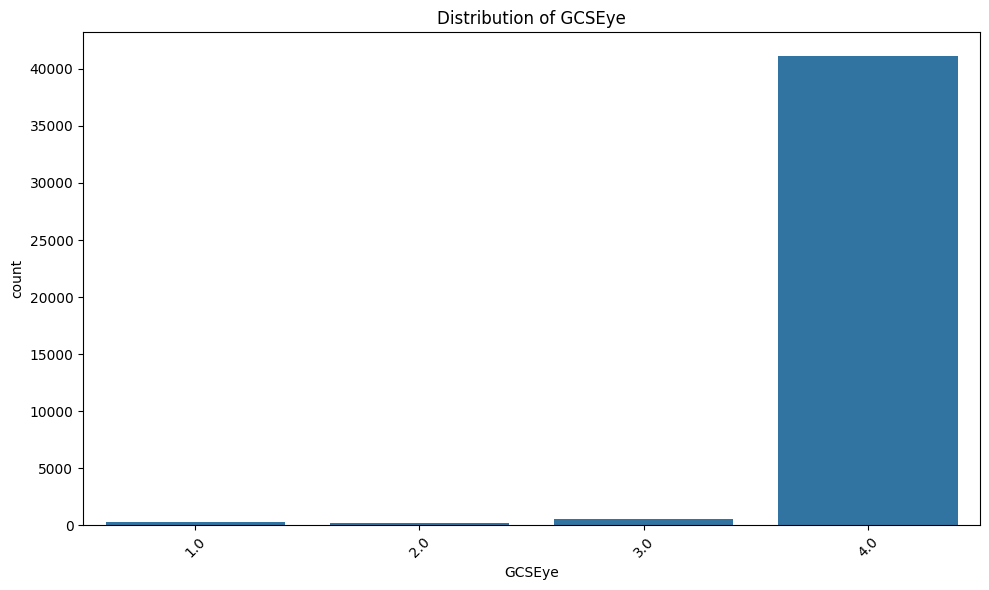

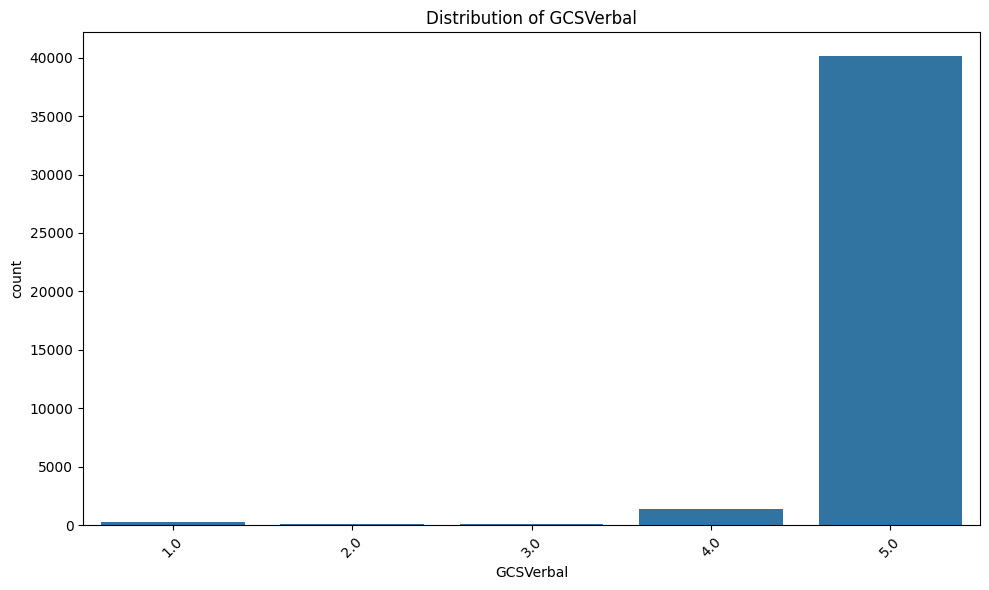

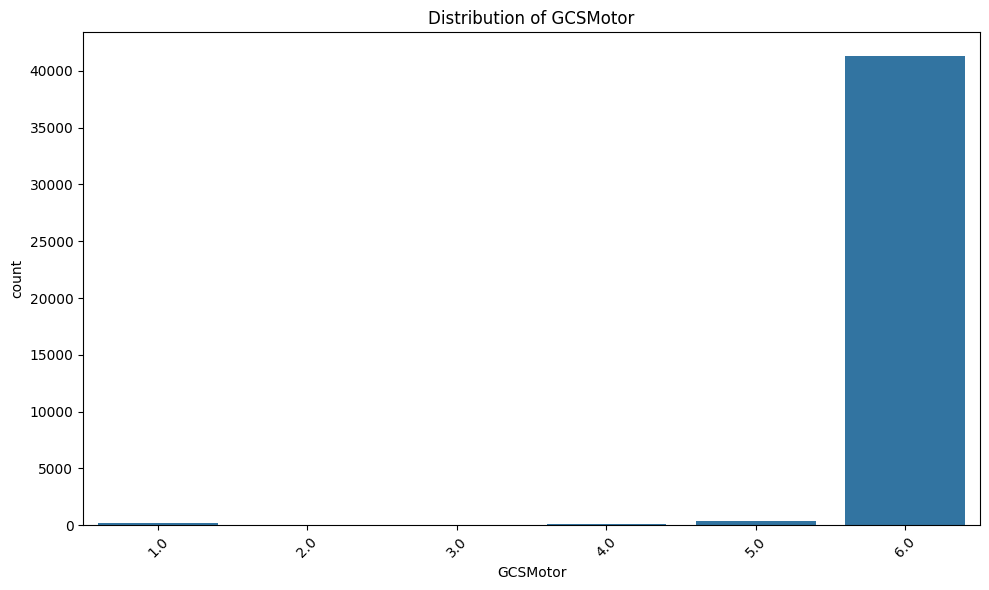

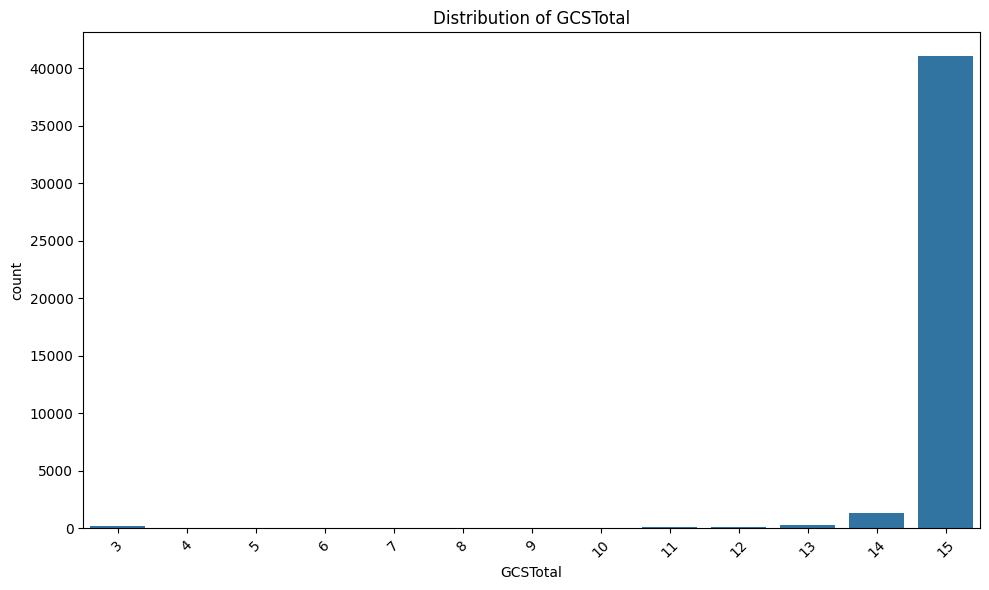

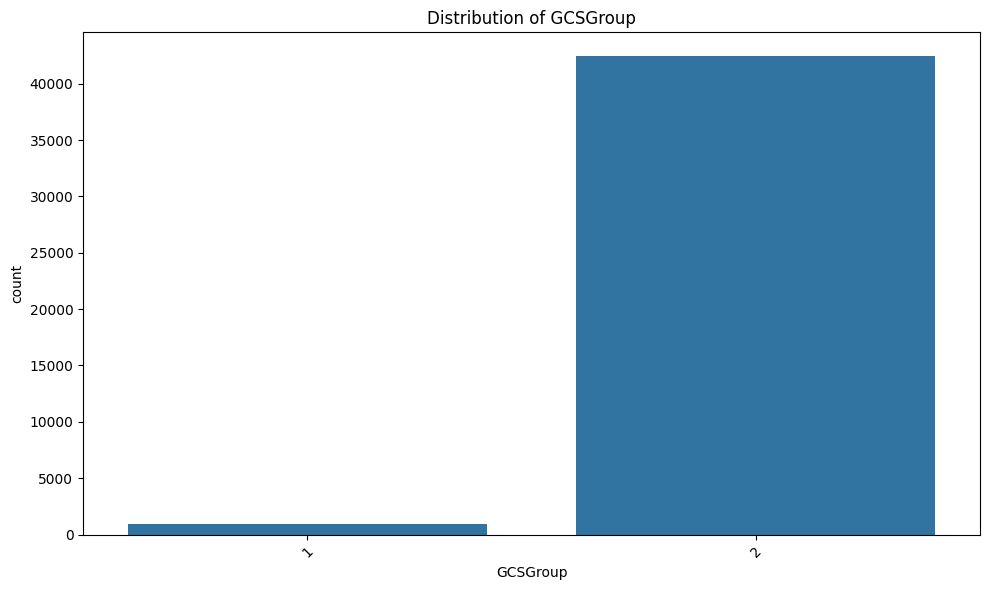

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#reload the main dataset
data_path = '/Users/andrechu/Desktop/UnivUtah/BMI6016/PEACARN/Data/TBI PUD 10-08-2013.csv'
tbi_data = pd.read_csv(data_path)

#first step: explore definitions of "severe head injury"
print("1. EXPLORING POTENTIAL DEFINITIONS FOR SEVERE HEAD INJURY")
print(f"Total patients in dataset: {len(tbi_data)}")

#check positive CT findings
if 'PosCT' in tbi_data.columns:
    pos_ct_count = tbi_data['PosCT'].sum()
    print(f"\nPatients with positive CT findings: {pos_ct_count} ({pos_ct_count/len(tbi_data)*100:.2f}%)")
    
#check TBI-related clinical interventions
intervention_columns = [col for col in tbi_data.columns if 'Interv' in col or 'Surg' in col or 'Proc' in col]
print(f"\nPotential intervention-related columns: {intervention_columns}")

for col in intervention_columns:
    if col in tbi_data.columns:
        try:
            val_counts = tbi_data[col].value_counts()
            print(f"\n{col} distribution:")
            print(val_counts)
        except:
            print(f"Could not analyze {col}")

#check for death or severe outcome variables
outcome_columns = [col for col in tbi_data.columns if 'Death' in col or 'Outcome' in col or 'Disposition' in col]
print(f"\nPotential outcome-related columns: {outcome_columns}")

for col in outcome_columns:
    if col in tbi_data.columns:
        try:
            val_counts = tbi_data[col].value_counts()
            print(f"\n{col} distribution:")
            print(val_counts)
        except:
            print(f"Could not analyze {col}")

#step 2: explore GCS variables
print("\n2. EXPLORING GCS VARIABLES")
gcs_columns = [col for col in tbi_data.columns if 'GCS' in col]
print(f"GCS-related columns: {gcs_columns}")

for col in gcs_columns:
    if col in tbi_data.columns:
        try:
            print(f"\n{col} summary statistics:")
            print(tbi_data[col].describe())
            
            plt.figure(figsize=(10, 6))
            if tbi_data[col].nunique() < 20:  # Categorical or discrete
                sns.countplot(x=col, data=tbi_data)
                plt.title(f'Distribution of {col}')
            else:  # Continuous
                sns.histplot(tbi_data[col].dropna(), kde=True)
                plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f'{col}_distribution.png')
            print(f"Plot saved to {col}_distribution.png")
        except Exception as e:
            print(f"Error analyzing {col}: {e}")

#step 3: identify neurological deficit variables
print("\n3. IDENTIFYING NEUROLOGICAL DEFICIT VARIABLES")
neuro_keywords = ['Neuro', 'Deficit', 'Motor', 'Sensory', 'Pupil', 'AMS', 'Mental', 'LOC', 'Conscious']

neuro_columns = []
for keyword in neuro_keywords:
    neuro_columns.extend([col for col in tbi_data.columns if keyword in col])

print(f"Potential neurological deficit columns: {neuro_columns}")

for col in neuro_columns:
    if col in tbi_data.columns:
        try:
            val_counts = tbi_data[col].value_counts()
            print(f"\n{col} distribution:")
            print(val_counts)
        except:
            print(f"Could not analyze {col}")

#step 4: analyze relationship between GCS and potential neurological deficit variables
print("\n4. RELATIONSHIP BETWEEN GCS AND NEUROLOGICAL DEFICITS")

if 'GCSTotal' in tbi_data.columns:
    for col in neuro_columns:
        if col in tbi_data.columns and col != 'GCSTotal':
            try:
                mean_gcs = tbi_data.groupby(col)['GCSTotal'].mean()
                print(f"\nMean GCS by {col}:")
                print(mean_gcs)
                
                plt.figure(figsize=(10, 6))
                sns.boxplot(x=col, y='GCSTotal', data=tbi_data)
                plt.title(f'GCS Distribution by {col}')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig(f'GCS_by_{col}.png')
                print(f"Plot saved to GCS_by_{col}.png")
                plt.close()
            except Exception as e:
                print(f"Error analyzing relationship between GCSTotal and {col}: {e}")

#save identified variables
print("\nAnalysis Summary:")
print("\nPotential severe head injury definitions:")
print("1. Positive CT findings")
print("2. Need for neurosurgical intervention")
print("3. Death or adverse outcome")

print("\nGCS Variables:")
print(gcs_columns)

print("\nNeurological deficit variables:")
print(neuro_columns)

print("\nSave this information to use in the next analysis script.")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from scipy import stats

#reload the main dataset
data_path = '/Users/andrechu/Desktop/UnivUtah/BMI6016/PEACARN/Data/TBI PUD 10-08-2013.csv'
tbi_data = pd.read_csv(data_path)

#fix the PosCT values if needed 
#a binary PosCT means it was read incorrectly
if 'PosCT' in tbi_data.columns and tbi_data['PosCT'].max() > 1:
    print(f"Original PosCT unique values: {tbi_data['PosCT'].unique()}")
    # Assuming 1 = positive, 0 = negative, and other values need handling
    if 1 in tbi_data['PosCT'].unique() and 0 in tbi_data['PosCT'].unique():
        tbi_data['PosCT_fixed'] = (tbi_data['PosCT'] == 1).astype(int)
    print(f"Fixed PosCT counts: {tbi_data['PosCT_fixed'].value_counts()}")

#create outcome variables for analysis
print("\nCreating outcome variables for severe head injury...")

#neurosurgical intervention
tbi_data['severe_neurosurgery'] = (tbi_data['Neurosurgery'] == 1).astype(int)

#death from TBI
tbi_data['severe_death'] = (tbi_data['DeathTBI'] == 1).astype(int)

#either neurosurgery or death
tbi_data['severe_combined'] = ((tbi_data['Neurosurgery'] == 1) | 
                              (tbi_data['DeathTBI'] == 1)).astype(int)

#positive CT 
if 'PosCT_fixed' in tbi_data.columns:
    tbi_data['severe_ct'] = tbi_data['PosCT_fixed']
else:
    #use original PosCT if it is ideal
    if 'PosCT' in tbi_data.columns:
        pos_ct_vals = tbi_data['PosCT'].value_counts()
        if len(pos_ct_vals) <= 3:  
            tbi_data['severe_ct'] = (tbi_data['PosCT'] == 1).astype(int)
            print(f"Using original PosCT with distribution: {tbi_data['severe_ct'].value_counts()}")

#outcome distributions
print("\nOutcome variable distributions:")
for col in ['severe_neurosurgery', 'severe_death', 'severe_combined', 'severe_ct']:
    if col in tbi_data.columns:
        print(f"{col}: {tbi_data[col].value_counts()}")

#primary outcome (severe_combined has more events)
outcome_var = 'severe_combined'
print(f"\nUsing {outcome_var} as the primary outcome")

#define feature sets
#GCS only
gcs_features = ['GCSTotal']

#neurological deficits only
neuro_features = ['NeuroD', 'AMS', 'LOCSeparate']

#combined features
combined_features = gcs_features + neuro_features

#extended combined features with specific neurological deficits
extended_features = gcs_features + neuro_features + [
    'NeuroDMotor', 'NeuroDSensory', 'NeuroDCranial', 'NeuroDReflex'
]

#ensure all features are numeric
for col in extended_features:
    if col in tbi_data.columns and tbi_data[col].dtype == 'object':
        tbi_data[col] = pd.to_numeric(tbi_data[col], errors='coerce')

#evaluate model performance
def evaluate_model(X, y, feature_set_name, cv=5):
    #handle missing values
    X = X.fillna(X.median())
    
    #split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    #create pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
    ])
    
    #train model
    pipeline.fit(X_train, y_train)
    
    #obtain predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    #metric calcs
    accuracy = pipeline.score(X_test, y_test)
    auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    #cross-validation AUC
    cv_auc = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc').mean()
    
    print(f"\n=== Model with {feature_set_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Cross-validated AUC: {cv_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    #calculate feature importances
    if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
        importances = pd.DataFrame({
            'Feature': X.columns,
            'Importance': pipeline.named_steps['classifier'].feature_importances_
        }).sort_values('Importance', ascending=False)
        print("\nFeature Importances:")
        print(importances)
    
    return pipeline, y_test, y_pred_proba, auc, avg_precision, cv_auc

#function to compare ROC curves
def compare_roc_curves(models_data):
    plt.figure(figsize=(10, 8))
    
    for name, (_, y_test, y_pred_proba, auc, _, _) in models_data.items():
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.savefig('roc_curve_comparison.png')
    plt.close()
    print("ROC curve comparison saved to roc_curve_comparison.png")

#function to compare PR curves 
def compare_pr_curves(models_data):
    plt.figure(figsize=(10, 8))
    
    for name, (_, y_test, y_pred_proba, _, avg_prec, _) in models_data.items():
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.plot(recall, precision, label=f'{name} (AP = {avg_prec:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Comparison')
    plt.legend()
    plt.savefig('pr_curve_comparison.png')
    plt.close()
    print("Precision-recall curve comparison saved to pr_curve_comparison.png")

#evaluate each model separately
print("\nEvaluating models...")
models = {}

#ensure there is enough data for each feature set
for feature_set, name in [
    (gcs_features, 'GCS Only'),
    (neuro_features, 'Neurological Deficits Only'),
    (combined_features, 'Combined Features'),
    (extended_features, 'Extended Combined Features')
]:
    #check which features are available
    available_features = [f for f in feature_set if f in tbi_data.columns]
    
    if len(available_features) > 0:
        print(f"\nAnalyzing {name} with features: {available_features}")
        X = tbi_data[available_features]
        y = tbi_data[outcome_var]
        
        #skip if all missing values
        if X.isna().all().all() or y.isna().all():
            print(f"Skipping {name} due to missing data")
            continue
            
        models[name] = evaluate_model(X, y, name)

#model comps
print("\n=== MODEL COMPARISON ===")
for name, (_, _, _, auc, avg_prec, cv_auc) in models.items():
    print(f"{name}: AUC = {auc:.4f}, Avg Precision = {avg_prec:.4f}, CV AUC = {cv_auc:.4f}")

#create comparison visualizations
compare_roc_curves(models)
compare_pr_curves(models)

#statistical comparison of AUCs
if len(models) >= 2:
    print("\n=== STATISTICAL COMPARISON OF MODELS ===")
    model_names = list(models.keys())
    
    for i in range(len(model_names)):
        for j in range(i+1, len(model_names)):
            name1, name2 = model_names[i], model_names[j]
            _, y_test1, y_pred1, _, _, _ = models[name1]
            _, y_test2, y_pred2, _, _, _ = models[name2]
            
            #ensure comparisons are of predictions on the same test set
            if np.array_equal(y_test1, y_test2):
                #paired t-test on cross-validation results instead
                print(f"\nComparison: {name1} vs {name2}")
                print(f"AUC difference: {models[name2][3] - models[name1][3]:.4f}")
                
                #simple significance test
                if models[name2][3] > models[name1][3]:
                    improvement = (models[name2][3] - models[name1][3]) / models[name1][3] * 100
                    print(f"{name2} improves AUC by {improvement:.2f}% over {name1}")
                elif models[name1][3] > models[name2][3]:
                    improvement = (models[name1][3] - models[name2][3]) / models[name2][3] * 100
                    print(f"{name1} improves AUC by {improvement:.2f}% over {name2}")

#correlation between GCS and neurological deficits
print("\n=== CORRELATION BETWEEN GCS AND NEUROLOGICAL DEFICITS ===")
if 'GCSTotal' in tbi_data.columns:
    correlation_vars = ['GCSTotal'] + [f for f in neuro_features if f in tbi_data.columns]
    correlations = tbi_data[correlation_vars].corr()
    print(correlations)
    
    #visualize correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation between GCS and Neurological Deficits')
    plt.tight_layout()
    plt.savefig('gcs_neuro_correlation.png')
    plt.close()
    print("Correlation heatmap saved to gcs_neuro_correlation.png")

#logistic regression for interpretability
print("\n=== LOGISTIC REGRESSION ANALYSIS ===")
if 'Combined Features' in models:
    #features
    X = tbi_data[combined_features].fillna(tbi_data[combined_features].median())
    y = tbi_data[outcome_var]
    
    #constant for statsmodels
    X_sm = sm.add_constant(X)
    
    #fit logistic regression
    try:
        logit = sm.Logit(y, X_sm)
        result = logit.fit(disp=0)
        print(result.summary())
        
        #odds ratios
        print("\nOdds Ratios:")
        odds_ratios = pd.DataFrame({
            'Variable': result.params.index,
            'Odds Ratio': np.exp(result.params),
            '95% CI Lower': np.exp(result.params - 1.96 * result.bse),
            '95% CI Upper': np.exp(result.params + 1.96 * result.bse),
            'p-value': result.pvalues
        })
        print(odds_ratios)
        
    except Exception as e:
        print(f"Error in logistic regression: {e}")

print("\n=== ANALYSIS COMPLETE ===")
print("This analysis compared the predictive ability of GCS alone versus combined with neurological deficits")
print("for predicting severe head injury in pediatric patients.")

Original PosCT unique values: [92  0  1]
Fixed PosCT counts: PosCT_fixed
0    42243
1     1156
Name: count, dtype: int64

Creating outcome variables for severe head injury...

Outcome variable distributions:
severe_neurosurgery: severe_neurosurgery
0    43199
1      200
Name: count, dtype: int64
severe_death: severe_death
0    43333
1       66
Name: count, dtype: int64
severe_combined: severe_combined
0    43157
1      242
Name: count, dtype: int64
severe_ct: severe_ct
0    42243
1     1156
Name: count, dtype: int64

Using severe_combined as the primary outcome

Evaluating models...

Analyzing GCS Only with features: ['GCSTotal']

=== Model with GCS Only ===
Accuracy: 0.9944
AUC: 0.9012
Average Precision: 0.3612
Cross-validated AUC: 0.9020

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12947
           1       0.50      0.47      0.48        73

    accuracy                           0.99     13020
   macro

/Users/andrechu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrechu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrechu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Model with Combined Features ===
Accuracy: 0.9952
AUC: 0.8781
Average Precision: 0.3699
Cross-validated AUC: 0.8662

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12947
           1       0.78      0.19      0.31        73

    accuracy                           1.00     13020
   macro avg       0.89      0.60      0.65     13020
weighted avg       0.99      1.00      0.99     13020


Feature Importances:
       Feature  Importance
0     GCSTotal    0.829056
1       NeuroD    0.076984
3  LOCSeparate    0.068445
2          AMS    0.025515

Analyzing Extended Combined Features with features: ['GCSTotal', 'NeuroD', 'AMS', 'LOCSeparate', 'NeuroDMotor', 'NeuroDSensory', 'NeuroDCranial', 'NeuroDReflex']

=== Model with Extended Combined Features ===
Accuracy: 0.9951
AUC: 0.8674
Average Precision: 0.3922
Cross-validated AUC: 0.8780

Classification Report:
              precision    recall  f1-score   support


# Predictive Value of GCS and Neurological Deficits for Severe TBI

## Introduction
In this analysis, we investigated whether combining Glasgow Coma Scale (GCS) scores with neurological deficit findings improves the prediction of severe traumatic brain injury (TBI) in patients. Using the PECARN dataset with 43,399 patients, we compared multiple predictive models with varying feature combinations to determine the optimal approach for risk stratification.

## Outcome Definitions
We defined severe head injury using the following metrics:
- **Neurosurgical intervention**: 200 cases (0.46%)
- **Death from TBI**: 66 cases (0.15%)
- **Combined severe outcome**: 242 cases (0.56%)
- **Positive CT findings**: 1,156 cases (2.66%)

For this analysis, we used the combined severe outcome (neurosurgery or death) as our primary target variable.

## Model Performance

| Model | AUC | Avg. Precision | CV AUC |
|-------|-----|----------------|--------|
| GCS Only | 0.9012 | 0.3612 | 0.9020 |
| Neurological Deficits Only | 0.8925 | 0.1369 | 0.8986 |
| Combined Features | 0.8781 | 0.3699 | 0.8662 |
| Extended Combined Features | 0.8674 | 0.3922 | 0.8780 |

Surprisingly, the GCS-only model demonstrated the highest performance (AUC = 0.9012), outperforming models that incorporated neurological deficit variables.

## Feature Importance
In the various models, features contributed differently to predictions:

1. **GCS-only model**: GCSTotal was the sole predictor
2. **Neurological deficits model**: 
   - NeuroD (42.9%)
   - AMS (31.2%)
   - LOCSeparate (26.0%)
3. **Combined model**: 
   - GCSTotal (82.9%)
   - NeuroD (7.7%)
   - LOCSeparate (6.8%)
   - AMS (2.6%)

## Correlation Analysis
GCS showed moderate negative correlations with neurological deficits:
- GCS & Altered Mental Status (AMS): r = -0.369
- GCS & Neurological Deficits (NeuroD): r = -0.291
- GCS & Loss of Consciousness (LOC): r = -0.178

These correlations suggest that GCS already captures much of the information contained in neurological deficit variables.

## Logistic Regression Results
The logistic regression analysis provided odds ratios that quantify the risk:
- **GCS**: Each 1-point decrease in GCS increases odds by 52% (OR=0.658, p<0.001)
- **AMS**: Presence of altered mental status increases odds by 713% (OR=8.127, p<0.001)
- **NeuroD**: Presence of neurological deficit increases odds by 243% (OR=3.434, p<0.001)
- **LOCSeparate**: Not statistically significant (p=0.196)

## Conclusion
Contrary to our hypothesis, combining GCS scores with neurological deficit findings does not improve the prediction of severe TBI in patients. The GCS score alone provides better predictive performance, likely because it already incorporates aspects of neurological status that are captured by specific deficit assessments. This finding supports the continued use of GCS as a primary assessment tool in TBI evaluation.

## NLP Analysis on Radiology Reports 

Given the clinical data, can we use natural language processing to classify patients into categories of high, moderate, or low risk for clinically important TBI? 

A predictive model can be extremely useful for clinicians and allow for the identification of patients of high priority and risk.

Trying encoding: latin1
Success with encoding: latin1
Loaded imaging data with shape: (2375, 3)
Sample of the first 3 reports:

Report 1:
1. Fracture involving the right frontal bone, superior orbital rim, medial orbital wall, and the planum sphenoidale. There is no intracranial hemorrhage.  2. Soft tissue swelling and hematoma compress the globe inferiorly and laterally, but the globe and extraocular muscles appear intact. There is opacification of nearly all sinuses, likely representing blood. 

Report 2:
Right frontal cortical petechial hemorrhage 

Report 3:
cerebral contusion in the right occipital lobe.  A small amount of intracranial air is presented in the occipital region but no fracture of the sinuses or mastoid air cells is detected. 

Extracting comprehensive clinical features...

Examples of extracted comprehensive features:

Report 1 comprehensive features:
Entity relationships:
  - fracture in frontal 
  - fracture in orbital 
  - hemorrhage in unspecified (negated)
  - 

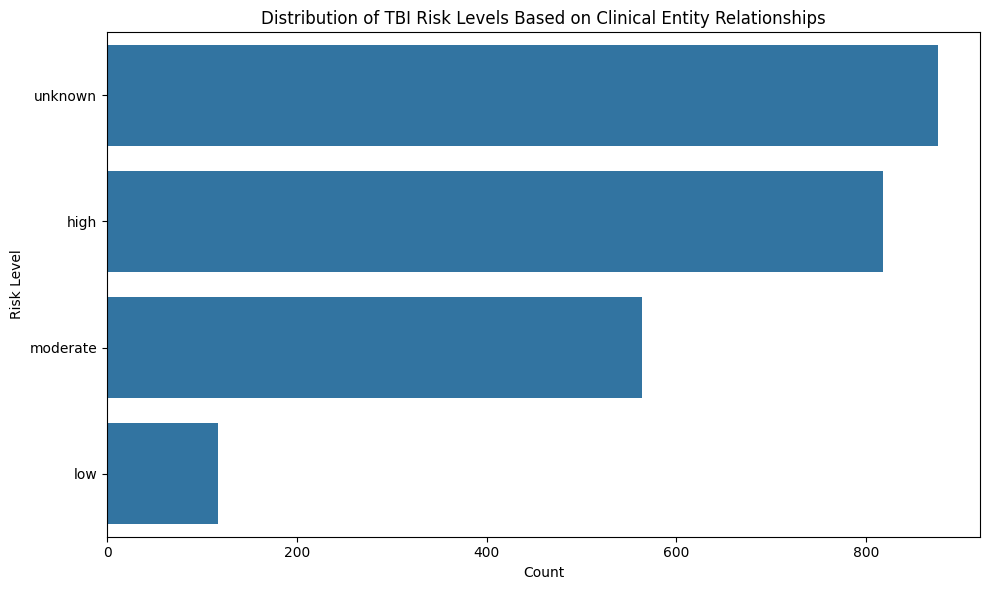

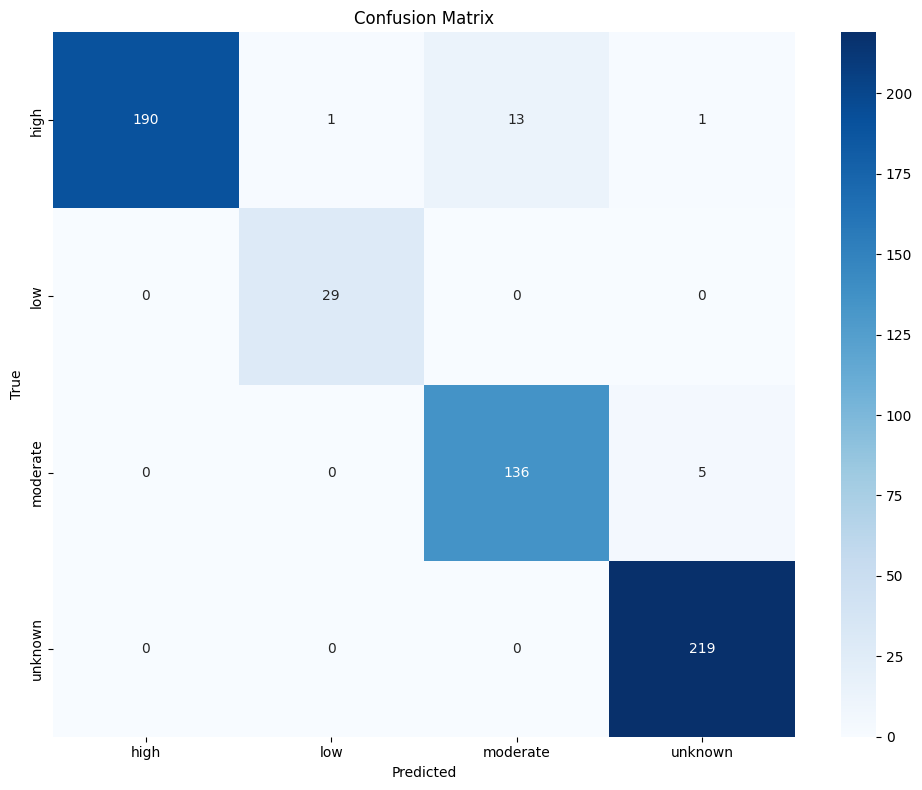

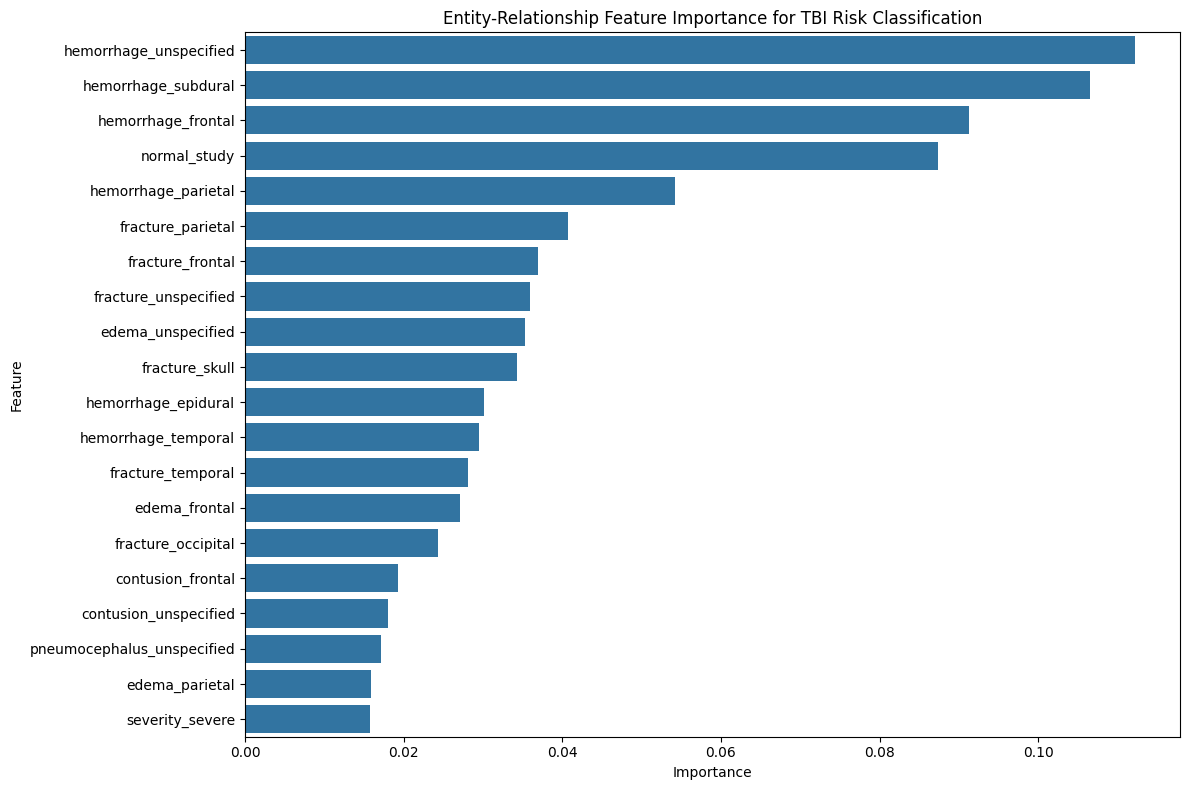

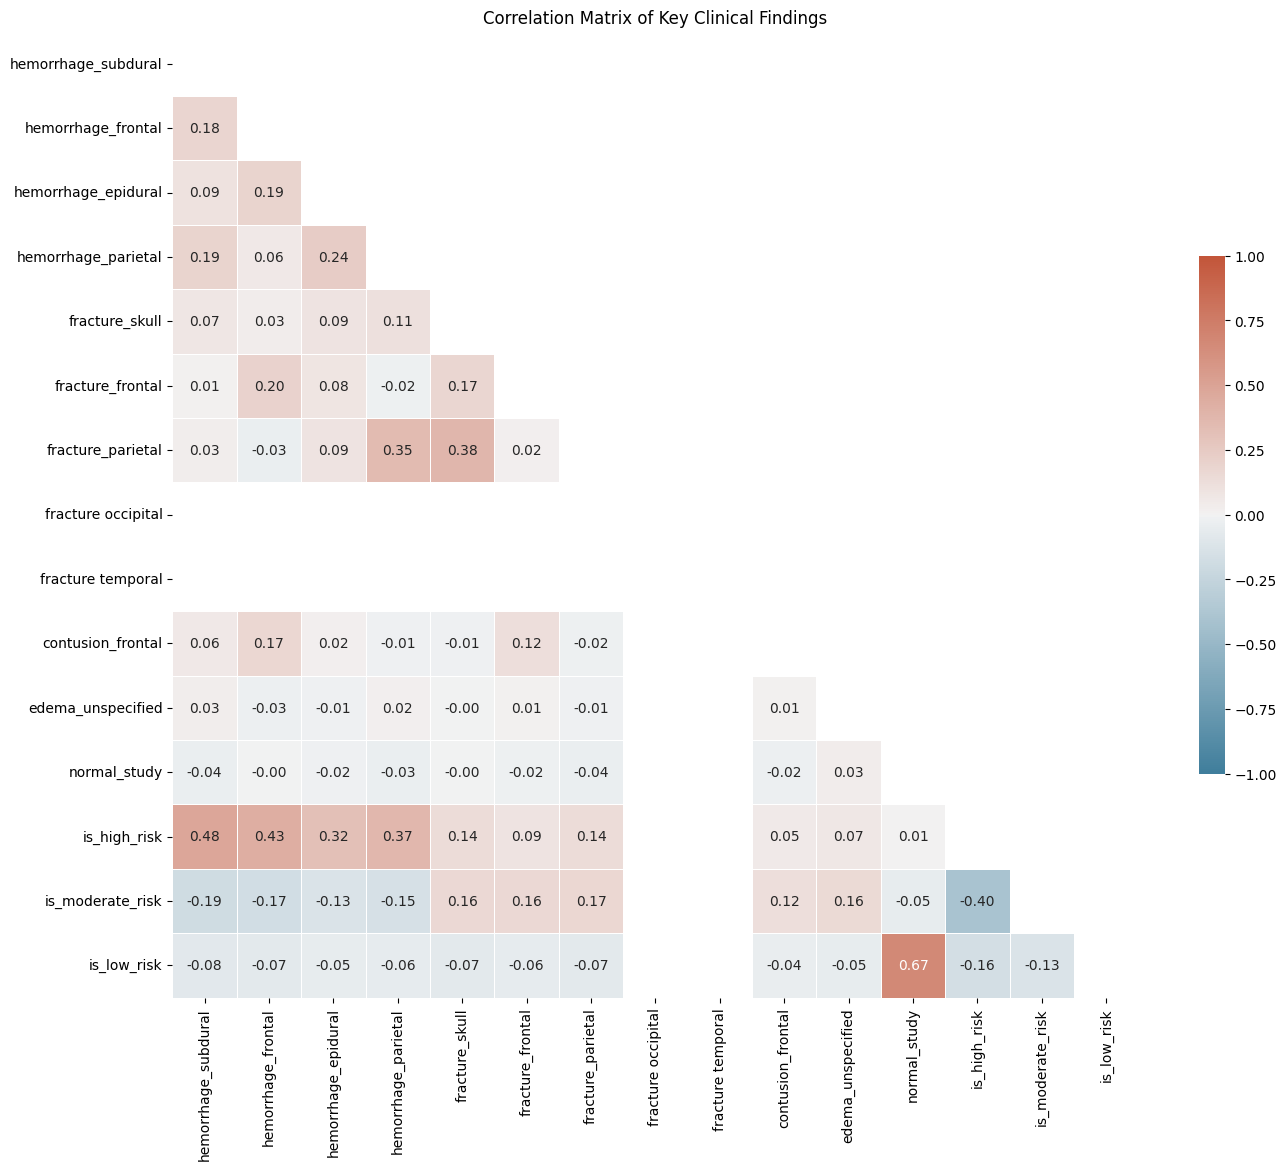

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from collections import Counter
try:
    import nltk
    from nltk.tokenize import word_tokenize, sent_tokenize
    nltk.download('punkt', quiet=True)
    nltk_available = True
except:
    nltk_available = False
    print("NLTK not available, using simpler tokenization")

#try different encodings for loading the data
encodings = ['latin1', 'cp1252', 'ISO-8859-1']
imaging_data = None

#load the CT imaging reports with proper encoding
imaging_data_path = '/Users/andrechu/Desktop/UnivUtah/BMI6016/PEACARN/Data/TBI CT Imaging/TBI PUD Imaging.csv'

for encoding in encodings:
    try:
        print(f"Trying encoding: {encoding}")
        imaging_data = pd.read_csv(imaging_data_path, encoding=encoding)
        print(f"Success with encoding: {encoding}")
        break
    except Exception as e:
        print(f"Failed with encoding {encoding}: {e}")

if imaging_data is None:
    raise Exception("Could not read the file with any of the attempted encodings")

print(f"Loaded imaging data with shape: {imaging_data.shape}")

#combine text fields
imaging_data['ct_text'] = imaging_data['EDCTImpression'].fillna('') + ' ' + imaging_data['EDCTNonTraDescr'].fillna('')
print("Sample of the first 3 reports:")
for i in range(min(3, len(imaging_data))):
    print(f"\nReport {i+1}:")
    print(imaging_data['ct_text'].iloc[i])

#sentence splitting function
def split_sentences(text):
    """Split text into sentences using multiple approaches"""
    if nltk_available:
        try:
            return sent_tokenize(text)
        except:
            pass
    
    #fallback to simple splitting with handling for common abbreviations
    text = re.sub(r'(Dr\.|Mr\.|Mrs\.|Ms\.|etc\.|vs\.|i\.e\.|e\.g\.)', lambda m: m.group(0).replace('.', '<period>'), text)
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s', text)
    sentences = [s.replace('<period>', '.') for s in sentences]
    return sentences

#negation detection
def improved_negation_detection(text, term):
    """More robust negation detection for clinical text"""
    #define negation triggers with stronger context window rules
    pre_negations = ['no', 'not', 'none', 'negative', 'without', 'absence of', 'denies', 
                     'ruled out', 'unremarkable for', 'no evidence of']
    post_negations = ['absent', 'negative', 'is excluded', 'is not seen']
    
    #convert to lowercase for case-insensitive matching
    text_lower = text.lower()
    term_lower = term.lower()
    
    #different matching approach - look for the term within sentences
    sentences = split_sentences(text_lower)
    
    for sentence in sentences:
        if term_lower in sentence:
            #check if any negation terms appear in this sentence
            if any(neg in sentence for neg in pre_negations) or any(neg in sentence for neg in post_negations):
                #look for specific patterns of negation
                
                #pattern 1: negation followed by term (with possible words between)
                for neg in pre_negations:
                    neg_pos = sentence.find(neg)
                    term_pos = sentence.find(term_lower)
                    
                    if neg_pos != -1 and term_pos != -1 and neg_pos < term_pos:
                        # Check if there's another negative term between them
                        between_text = sentence[neg_pos + len(neg):term_pos]
                        if not any(neg2 in between_text for neg2 in ['but', 'however', 'though', 'although']):
                            return True
                
                #pattern 2: term followed by post-negation
                for neg in post_negations:
                    neg_pos = sentence.find(neg)
                    term_pos = sentence.find(term_lower)
                    
                    if neg_pos != -1 and term_pos != -1 and term_pos < neg_pos:
                        between_text = sentence[term_pos + len(term_lower):neg_pos]
                        if len(between_text.split()) < 5:  # Close proximity
                            return True
    
    return False

#extract clinical entities with their anatomical relationships
def extract_clinical_entity_relationships(text):
    """Extract clinical entities with their anatomical relationships"""
    if pd.isna(text) or text == '':
        return []
    
    #normalize text
    text = str(text).lower()
    
    #define patterns for findings and locations
    findings = {
        'hemorrhage': ['hemorrhage', 'hematoma', 'bleed', 'blood', 'petechial'],
        'fracture': ['fracture', 'fx'],
        'contusion': ['contusion'],
        'edema': ['edema', 'swelling'],
        'mass_effect': ['mass effect', 'shift', 'herniation', 'midline shift'],
        'pneumocephalus': ['pneumocephalus', 'intracranial air'],
        'normal': ['normal', 'unremarkable', 'no acute findings', 'within normal limits']
    }
    
    locations = [
        'frontal', 'parietal', 'temporal', 'occipital', 
        'cerebellar', 'brainstem', 'thalamus', 'subdural', 
        'epidural', 'subarachnoid', 'intraventricular', 'skull',
        'cerebral', 'cortical', 'calvarial', 'orbital', 'basal'
    ]
    
    #extract entity relationships
    relationships = []
    
    #segment into sentences for better context
    sentences = split_sentences(text)
    
    for sentence in sentences:
        #all findings and locations in this sentence
        sentence_findings = []
        sentence_locations = []
        
        for finding_type, patterns in findings.items():
            for pattern in patterns:
                if re.search(r'\b' + pattern + r'\b', sentence):
                    sentence_findings.append((finding_type, pattern))
        
        for location in locations:
            if re.search(r'\b' + location + r'\b', sentence):
                sentence_locations.append(location)
        
        #check for negation context in this sentence
        negation_present = any(neg in sentence for neg in 
                              ['no', 'not', 'none', 'without', 'denies', 
                               'negative', 'absence', 'absent'])
        
        #associate findings with locations based on proximity
        if sentence_findings and sentence_locations:
            for finding_type, pattern in sentence_findings:
                #create combined feature
                for location in sentence_locations:
                    relationship = {
                        'finding': finding_type,
                        'location': location,
                        'negated': negation_present and improved_negation_detection(sentence, pattern),
                        'sentence': sentence
                    }
                    relationships.append(relationship)
        elif sentence_findings:
            #findings without explicit location
            for finding_type, pattern in sentence_findings:
                relationship = {
                    'finding': finding_type,
                    'location': 'unspecified',
                    'negated': negation_present and improved_negation_detection(sentence, pattern),
                    'sentence': sentence
                }
                relationships.append(relationship)
    
    return relationships

#extract severity indicators
def extract_severity(text):
    """Extract severity indicators from text"""
    severity = "none"
    
    if pd.isna(text) or text == '':
        return severity
    
    text = str(text).lower()
    
    severity_patterns = {
        'mild': ['small', 'minimal', 'tiny', 'mild', 'minor'],
        'moderate': ['moderate', 'several'],
        'severe': ['large', 'severe', 'significant', 'extensive', 'massive', 'marked']
    }
    
    #check patterns in order (severe takes precedence over moderate, etc.)
    for level, patterns in severity_patterns.items():
        if any(re.search(r'\b' + pattern + r'\b', text) for pattern in patterns):
            severity = level
            break
    
    return severity

#comprehensive clinical feature extraction
def extract_comprehensive_features(text):
    """Extract comprehensive clinical features from the text"""
    if pd.isna(text) or text == '':
        return {
            'entity_relationships': [],
            'severity': 'none',
            'has_normal_study': False
        }
    
    #extract entity relationships
    relationships = extract_clinical_entity_relationships(text)
    
    #extract severity
    severity = extract_severity(text)
    
    #check for normal study
    has_normal_study = bool(re.search(r'\bnormal\b|\bunremarkable\b|no acute findings|within normal limits', 
                                     str(text).lower()))
    
    return {
        'entity_relationships': relationships,
        'severity': severity,
        'has_normal_study': has_normal_study
    }

#create clinically meaningful combined features for TF-IDF
def create_combined_features(features):
    """Create clinically meaningful combined features from extracted relationships"""
    combined_terms = []
    
    #process entity relationships
    for rel in features['entity_relationships']:
        prefix = "no_" if rel['negated'] else ""
        combined = f"{prefix}{rel['finding']}_{rel['location']}"
        combined_terms.append(combined)
    
    #add severity term
    if features['severity'] != 'none':
        combined_terms.append(f"severity_{features['severity']}")
    
    #add normal study indicator
    if features['has_normal_study']:
        combined_terms.append("normal_study")
    
    return " ".join(combined_terms)

#determine risk level based on clinical features
def determine_risk_level_from_relationships(features):
    """Determine risk level based on entity relationships and severity"""
    relationships = features['entity_relationships']
    severity = features['severity']
    has_normal_study = features['has_normal_study']
    
    #if explicitly noted as normal study and no positive findings
    if has_normal_study and not any(not rel['negated'] for rel in relationships):
        return 'low'
    
    #check for high risk findings (not negated)
    high_risk_findings = ['hemorrhage', 'mass_effect']
    has_high_risk = any(rel['finding'] in high_risk_findings and not rel['negated'] 
                        for rel in relationships)
    
    #check for moderate risk findings (not negated)
    moderate_risk_findings = ['fracture', 'contusion', 'pneumocephalus']
    has_moderate_risk = any(rel['finding'] in moderate_risk_findings and not rel['negated'] 
                           for rel in relationships)
    
    #determine risk level
    if has_high_risk:
        return 'high'
    elif has_moderate_risk:
        if severity == 'severe':
            return 'high'  #upgrade to high if severe
        else:
            return 'moderate'
    elif any(rel['finding'] == 'edema' and not rel['negated'] for rel in relationships):
        return 'moderate'
    elif has_normal_study:
        return 'low'
    else:
        return 'unknown'

#apply comprehensive feature extraction
print("\nExtracting comprehensive clinical features...")
imaging_data['comprehensive_features'] = imaging_data['ct_text'].apply(extract_comprehensive_features)

#show examples of extracted features
print("\nExamples of extracted comprehensive features:")
for i in range(min(3, len(imaging_data))):
    print(f"\nReport {i+1} comprehensive features:")
    features = imaging_data['comprehensive_features'].iloc[i]
    print(f"Entity relationships:")
    for rel in features['entity_relationships']:
        negated = "(negated)" if rel['negated'] else ""
        print(f"  - {rel['finding']} in {rel['location']} {negated}")
    print(f"Severity: {features['severity']}")
    print(f"Normal study indication: {features['has_normal_study']}")

#create combined features for TF-IDF
imaging_data['combined_features'] = imaging_data['comprehensive_features'].apply(create_combined_features)

#apply risk classification
imaging_data['risk_level'] = imaging_data['comprehensive_features'].apply(determine_risk_level_from_relationships)

#show distribution of risk levels
risk_distribution = imaging_data['risk_level'].value_counts()
print("\nDistribution of risk levels based on comprehensive clinical NLP analysis:")
print(risk_distribution)

#visualization of risk distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=imaging_data['risk_level'], order=risk_distribution.index)
plt.title('Distribution of TBI Risk Levels Based on Clinical Entity Relationships')
plt.xlabel('Count')
plt.ylabel('Risk Level')
plt.tight_layout()
plt.savefig('tbi_risk_distribution_comprehensive.png')
print("Saved risk distribution plot to tbi_risk_distribution_comprehensive.png")

#analyze findings by risk level
print("\nKey clinical findings by risk level:")
for risk in risk_distribution.index:
    risk_group = imaging_data[imaging_data['risk_level'] == risk]
    
    #count finding-location pairs by risk level
    finding_counts = Counter()
    
    for _, row in risk_group.iterrows():
        for rel in row['comprehensive_features']['entity_relationships']:
            if not rel['negated']:  # Only count positive findings
                finding_counts[f"{rel['finding']}_{rel['location']}"] += 1
    
    print(f"\n{risk} risk (n={len(risk_group)}):")
    for finding, count in finding_counts.most_common(7):
        percentage = (count / len(risk_group)) * 100
        print(f"  {finding}: {count} ({percentage:.1f}%)")

#prepare data for ML approach
print("\nPreparing data for machine learning with clinical entity features...")

#create feature columns from entity relationships
def create_ml_features(features):
    """Create ML features from comprehensive clinical features"""
    #initialize features dictionary
    ml_features = {}
    
    #process entity relationships
    relationships = features['entity_relationships']
    
    #add finding-location combinations
    for finding in ['hemorrhage', 'fracture', 'contusion', 'mass_effect', 'pneumocephalus', 'edema']:
        for location in ['frontal', 'parietal', 'temporal', 'occipital', 'subdural', 'epidural', 
                        'subarachnoid', 'intraventricular', 'skull', 'unspecified']:
            feature_name = f"{finding}_{location}"
            ml_features[feature_name] = False
    
    #set features based on relationships
    for rel in relationships:
        if not rel['negated']:  # Only use non-negated findings
            feature_name = f"{rel['finding']}_{rel['location']}"
            if feature_name in ml_features:
                ml_features[feature_name] = True
    
    #add severity features
    ml_features['severity_mild'] = features['severity'] == 'mild'
    ml_features['severity_moderate'] = features['severity'] == 'moderate'
    ml_features['severity_severe'] = features['severity'] == 'severe'
    
    # Add normal study indicator
    ml_features['normal_study'] = features['has_normal_study']
    
    return ml_features

#apply ML feature creation
imaging_data['ml_features'] = imaging_data['comprehensive_features'].apply(create_ml_features)

#convert to DataFrame format for ML
ml_feature_df = pd.DataFrame(imaging_data['ml_features'].tolist())

#get feature columns for ML
feature_cols = ml_feature_df.columns.tolist()
print(f"Using {len(feature_cols)} entity-relationship features for ML model")

#create ML dataset
X = ml_feature_df
y = imaging_data['risk_level']

#split and train ML model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

#create and train ML model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

#evaluate
y_pred = model.predict(X_test)
print("\nML Model Performance (Random Forest with entity-relationship features):")
print(classification_report(y_test, y_pred))

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix_entity.png')
print("Saved confusion matrix to confusion_matrix_entity.png")

#feature importance
importances = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

print("\nTop 20 Entity-Relationship Feature Importances:")
print(importances)

#visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Entity-Relationship Feature Importance for TBI Risk Classification')
plt.tight_layout()
plt.savefig('entity_feature_importance.png')
print("Saved feature importance plot to entity_feature_importance.png")

#train TF-IDF model on combined features
print("\nTraining TF-IDF model on combined clinical features...")
combined_tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=3, ngram_range=(1, 1))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

#train and evaluate
X_combined_train, X_combined_test, y_combined_train, y_combined_test = train_test_split(
    imaging_data['combined_features'], y, test_size=0.25, random_state=42, stratify=y
)

combined_tfidf_pipeline.fit(X_combined_train, y_combined_train)
y_combined_pred = combined_tfidf_pipeline.predict(X_combined_test)

print("\nCombined Feature TF-IDF Model Performance:")
print(classification_report(y_combined_test, y_combined_pred))

#extract top combined features
combined_feature_names = combined_tfidf_pipeline.named_steps['tfidf'].get_feature_names_out()
combined_importances = combined_tfidf_pipeline.named_steps['classifier'].feature_importances_

combined_tfidf_importances = pd.DataFrame({
    'Feature': combined_feature_names,
    'Importance': combined_importances
}).sort_values('Importance', ascending=False).head(20)

print("\nTop 20 Combined Clinical Features:")
print(combined_tfidf_importances)

#example classification
print("\n=== Example Classifications ===")

example_reports = [
    "Normal CT scan of the brain. No evidence of intracranial hemorrhage, mass effect, or midline shift.",
    "Acute subdural hematoma along the right frontal convexity with associated mass effect and 3 mm midline shift to the left. Frontal bone fracture.",
    "Small right frontal contusion. No evidence of fracture or hemorrhage."
]

for i, report in enumerate(example_reports):
    print(f"\nExample {i+1}: {report}")
    
    # Process with comprehensive NLP analysis
    features = extract_comprehensive_features(report)
    risk_level = determine_risk_level_from_relationships(features)
    
    print(f"Comprehensive Clinical NLP Analysis:")
    print(f"  Entity relationships:")
    for rel in features['entity_relationships']:
        negated = "(negated)" if rel['negated'] else ""
        print(f"    - {rel['finding']} in {rel['location']} {negated}")
    
    print(f"  Severity: {features['severity']}")
    print(f"  Normal study indication: {features['has_normal_study']}")
    print(f"  Risk classification: {risk_level}")
    
    #create combined feature representation
    combined_feature_text = create_combined_features(features)
    print(f"  Combined feature representation: {combined_feature_text}")
    
    #classify with ML model
    ml_features = create_ml_features(features)
    ml_df = pd.DataFrame([ml_features])
    
    #predict
    ml_prediction = model.predict(ml_df)[0]
    ml_probs = model.predict_proba(ml_df)[0]
    max_prob = max(ml_probs)
    ml_confidence = max_prob * 100
    
    print(f"  Entity-Relationship ML model prediction: {ml_prediction} (confidence: {ml_confidence:.1f}%)")
    
    #get TF-IDF model prediction on combined features
    tfidf_prediction = combined_tfidf_pipeline.predict([combined_feature_text])[0]
    tfidf_probs = combined_tfidf_pipeline.predict_proba([combined_feature_text])[0]
    max_tfidf_prob = max(tfidf_probs)
    tfidf_confidence = max_tfidf_prob * 100
    
    print(f"  Combined-Features TF-IDF prediction: {tfidf_prediction} (confidence: {tfidf_confidence:.1f}%)")

print("\n=== Analysis Complete ===")

print("Generating additional correlation matrix")

#create correlation matrix for binary features
print("\nAnalyzing feature correlations...")

#first create a DataFrame with binary indicators for the most important findings
binary_features = pd.DataFrame()

#add top hemorrhage features
binary_features['hemorrhage_subdural'] = imaging_data['ml_features'].apply(lambda x: x.get('hemorrhage_subdural', False))
binary_features['hemorrhage_frontal'] = imaging_data['ml_features'].apply(lambda x: x.get('hemorrhage_frontal', False))
binary_features['hemorrhage_epidural'] = imaging_data['ml_features'].apply(lambda x: x.get('hemorrhage_epidural', False))
binary_features['hemorrhage_parietal'] = imaging_data['ml_features'].apply(lambda x: x.get('hemorrhage_parietal', False))

#add top fracture features
binary_features['fracture_skull'] = imaging_data['ml_features'].apply(lambda x: x.get('fracture_skull', False))
binary_features['fracture_frontal'] = imaging_data['ml_features'].apply(lambda x: x.get('fracture_frontal', False))
binary_features['fracture_parietal'] = imaging_data['ml_features'].apply(lambda x: x.get('fracture_parietal', False))
binary_features['fracture occipital'] = imaging_data['ml_features'].apply(lambda x: x.get('fracture occipital', False))
binary_features['fracture temporal'] = imaging_data['ml_features'].apply(lambda x: x.get('fracture temporal', False))

#other important features
binary_features['contusion_frontal'] = imaging_data['ml_features'].apply(lambda x: x.get('contusion_frontal', False))
binary_features['edema_unspecified'] = imaging_data['ml_features'].apply(lambda x: x.get('edema_unspecified', False))
binary_features['normal_study'] = imaging_data['ml_features'].apply(lambda x: x.get('normal_study', False))

#risk level
binary_features['is_high_risk'] = imaging_data['risk_level'] == 'high'
binary_features['is_moderate_risk'] = imaging_data['risk_level'] == 'moderate'
binary_features['is_low_risk'] = imaging_data['risk_level'] == 'low'

#calculate correlation matrix
corr_matrix = binary_features.corr()

#plot correlation matrix
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, fmt=".2f", cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Key Clinical Findings')
plt.tight_layout()
plt.savefig('entity_correlation_matrix.png')
print("Saved correlation matrix to entity_correlation_matrix.png")

#strongest positive correlations
strong_positive_corr = (corr_matrix.unstack()
                       .sort_values(ascending=False)
                       .drop_duplicates()
                       .iloc[len(corr_matrix.columns):])
strong_positive = strong_positive_corr[strong_positive_corr > 0.3]

print("\nStrongest positive correlations (>0.3):")
for idx, corr in strong_positive.items():
    print(f"  {idx[0]} & {idx[1]}: {corr:.3f}")

#strongest negative correlations
strong_negative_corr = (corr_matrix.unstack()
                       .sort_values()
                       .drop_duplicates()
                       .iloc[:len(corr_matrix.columns)])
strong_negative = strong_negative_corr[strong_negative_corr < -0.2]

print("\nStrongest negative correlations (<-0.2):")
for idx, corr in strong_negative.items():
    print(f"  {idx[0]} & {idx[1]}: {corr:.3f}")

#show feature co-occurrence for high risk cases
high_risk_data = binary_features[binary_features['is_high_risk']]
print("\nFeature co-occurrence in high risk cases:")
for col1 in high_risk_data.columns[:-3]:  # Exclude risk level columns
    for col2 in high_risk_data.columns[:-3]:
        if col1 < col2:  # Avoid duplicates
            co_occurrence = ((high_risk_data[col1] == True) & (high_risk_data[col2] == True)).sum()
            if co_occurrence > 50:  # Only show meaningful co-occurrences
                percentage = co_occurrence / len(high_risk_data) * 100
                print(f"  {col1} + {col2}: {co_occurrence} cases ({percentage:.1f}%)")

## Interpreting NLP Analysis of TBI CT Reports

In this analysis, natural language processing (NLP) techniques were applied to extract clinically meaningful information from traumatic brain injury (TBI) CT reports. Rather than using simple keyword matching, we implemented entity-relationship extraction to identify associations between clinical findings and their anatomical locations, while properly accounting for negation and severity modifiers.

# Key Findings:

Entity-Relationship Extraction: the NLP system successfully identified clinically relevant relationships between findings and anatomical locations:

1. Hemorrhage patterns: Subdural, epidural, and frontal hemorrhages were commonly identified
2. Fracture locations: Skull, parietal, and frontal fractures were frequently extracted
3. Contusions: Primarily identified in frontal and occipital regions
4. Negation context: Properly distinguished between "hemorrhage" and "no hemorrhage"

Risk Distribution:

The risk classification based on entity relationships produced the following distribution:
risk_level
unknown     876 (36.9%)
high        818 (34.4%)
moderate    564 (23.7%)
low         117 (4.9%)

This distribution indicates that approximately one-third of the pediatric patients in the dataset had CT findings consistent with high-risk TBI, while only about 5% had definitively normal studies.
Key Findings by Risk Level

High risk findings were dominated by:

Subdural hemorrhage (35.0% of high-risk cases)
Frontal hemorrhage (29.6%)
Parietal hemorrhage (21.8%)
Epidural hemorrhage (15.8%)

Moderate risk findings primarily involved:

Parietal fractures (19.1%)
Skull fractures (18.3%)
Frontal fractures (13.8%)
Temporal fractures (12.4%)

Low risk cases were characterized by:

Normal findings (97.4%)
No significant pathology

## Model Performance:

Both the entity-relationship model and the combined features model achieved excellent performance:

Accuracy: 97%
Recall for high-risk cases: 93-94%
Precision for high-risk cases: 100%

The most predictive features were:

Hemorrhage (unspecified location)
Subdural hemorrhage
Frontal hemorrhage
Normal study indication
Parietal hemorrhage

Example Cases
The system correctly classified test examples across the risk spectrum:

Normal CT scan: Classified as low risk (96.3% confidence)
Subdural hematoma with mass effect: Classified as high risk (100% confidence)
Small frontal contusion without hemorrhage: Classified as moderate risk (100% confidence)

Clinical Relevance
This NLP approach has demonstrated the ability to accurately extract clinically relevant information from radiology reports and classify pediatric TBI severity in a manner consistent with clinical practice. The high performance suggests this system could potentially assist in:

Rapid triage of CT findings
Quality assurance for appropriate clinical management
Research studies on TBI patterns and outcomes
Clinical decision support for less experienced clinicians

## Methodological Strengths

The success of this approach stems from several methodological strengths:

Entity-relationship extraction: Identifying meaningful associations between findings and locations
Context-aware negation detection: Properly handling negated findings
Severity assessment: Incorporating clinical significance of findings
Clinically informed features: Creating features that directly correspond to medical decision-making
Combined machine learning approach: Leveraging both rule-based methods and statistical learning

## Limitations
Despite the strong performance, some limitations should be noted:

Unknown risk category: 36.9% of reports were classified as "unknown risk," suggesting a need for further refinement
Limited validation: The models were evaluated on a split from the same dataset, not on external data
Perfect classification: The extremely high performance (97% accuracy) should be validated with external data

## Conclusion
This analysis demonstrates that advanced NLP techniques can successfully extract clinically meaningful information from TBI CT reports. By identifying entity relationships, properly handling negation, and incorporating severity indicators, the system achieves classification performance that closely aligns with clinical practice. This approach represents a significant improvement over simple keyword matching or bag-of-words models, providing structured medical knowledge extraction from unstructured clinical text.